In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms as tr
from torchvision.models import vgg11_bn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint

from pathlib import Path
import pickle
from torch import nn


In [4]:
from inpainting.datasets.mnist import train_val_datasets
from inpainting.visualizations.digits import digit_with_mask as vis_digit_mask
from inpainting.training import train_inpainter
from inpainting.utils import classifier_experiment, inpainted, predictions_for_entire_loader
import inpainting.visualizations.samples as vis
from inpainting.datasets import mask_coding as mc
from inpainting.datasets.utils import RandomRectangleMaskConfig
from inpainting.custom_layers import Reshape
from inpainting.losses import nll_masked_batch_loss, nll_masked_batch_loss_components, r2_masked_batch_loss, nll_masked_batch_loss_same_size_masks
from inpainting.inpainters.mnist import MNISTLinearInpainter, MNISTConvolutionalInpainter, MNISTFullyConvolutionalInpainter
from inpainting import backbones as bkb

In [5]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = "white"

In [6]:
!ps aux | grep mprzewie

root       788  0.2  0.2 558332 145624 ?       Ssl  Apr04  34:22 /usr/sbin/glusterfs --acl --negative-timeout=60 --process-name fuse --volfile-server=s04.storage --volfile-server=s06.storage --volfile-id=gmum_home --subdir-mount=//home/mprzewiezlikowski /home/mprzewiezlikowski
root     11606  0.0  0.0  91308  7156 ?        Ss   Apr13   0:00 sshd: mprzewiezlikowski [priv]
mprzewi+ 11637  0.0  0.0  91792  5212 ?        S    Apr13   0:14 sshd: mprzewiezlikowski
mprzewi+ 21877  0.6  0.1 572052 104392 pts/18  Sl+  Apr13   6:49 /home/mprzewiezlikowski/anaconda3/envs/uj/bin/python /home/mprzewiezlikowski/anaconda3/envs/uj/bin/jupyter-lab --no-browser --port 6789
mprzewi+ 27582  6.2  0.3 2145488 222116 ?      Ssl  08:57   0:02 /home/mprzewiezlikowski/anaconda3/envs/uj/bin/python -m ipykernel_launcher -f /home/mprzewiezlikowski/.local/share/jupyter/runtime/kernel-89687c41-27bd-4a91-8080-427818799efa.json
mprzewi+ 27790  0.0  0.0   4500   756 pts/0    Ss+  08:57   0:00 /bin/sh -c ps aux | grep m

In [7]:
!echo $CUDA_VISIBLE_DEVICES
!nvidia-smi

0
Tue Apr 14 08:58:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 34%   49C    P0    61W / 250W |      0MiB / 11175MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 46%   79C    P2   137W / 250W |   1896MiB / 11178MiB |     42%      Default |
+-------------------------------+----------------------+----------------------+
|   2 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [9]:
experiment_path = Path("../results/mnist/fullconv/nll_simple_bkb")
experiment_path.mkdir(exist_ok=True, parents=True)

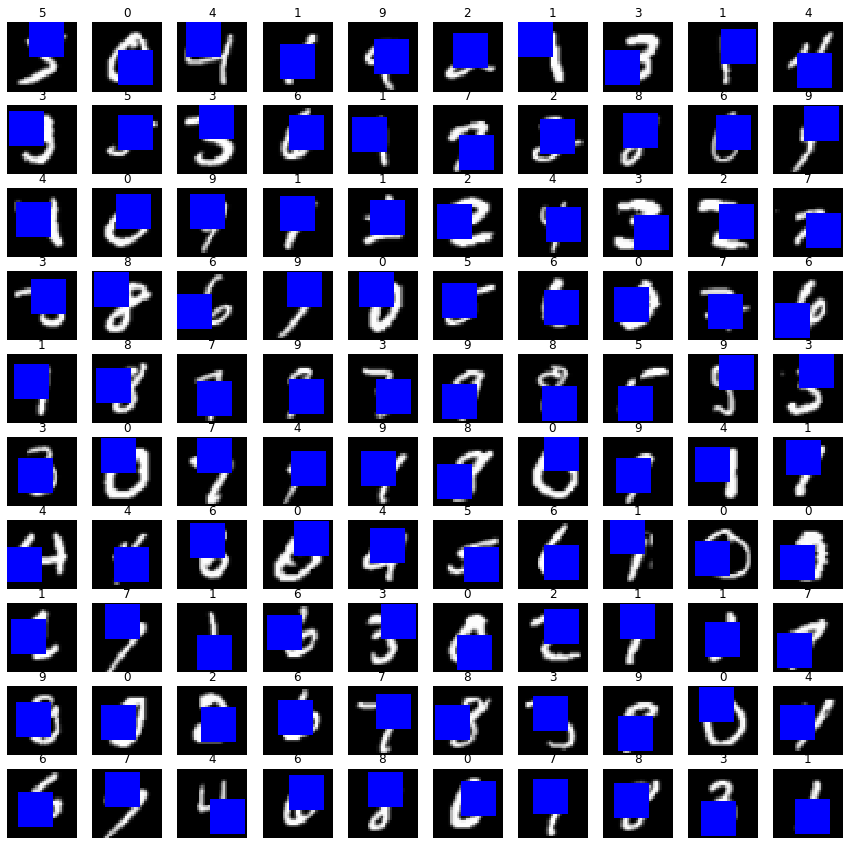

In [10]:
ds_train, ds_val = train_val_datasets(
    Path.home() / "uj/data/",
    mask_configs=[
#         RandomRectangleMaskConfig(mc.UNKNOWN_LOSS, 28,28, 0,0),

        RandomRectangleMaskConfig(mc.UNKNOWN_LOSS, 16, 16, 0,0),
#         RandomRectangleMaskConfig(mc.UNKNOWN_NO_LOSS, 14,14, 0,0)
    ],
    ds_type=MNIST,
    resize_size=(32,32)
)

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    (x,j), y = ds_train[i]
    ax = axes[i // 10, i%10]
    ax.set_title(f"{y}")
    vis_digit_mask(x, j,ax)
train_fig = plt.gcf()
train_fig.savefig(experiment_path / "train.png")
plt.show()

In [11]:
batch_size=96
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size, shuffle=True)

In [12]:
log_noms = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_noms"]

x_minus_means = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["x_minus_means"]

mse = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["x_minus_means_2"]

log_dets = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_dets"]

log_2_pi = lambda x,j,p,m,a,d : nll_masked_batch_loss_components(
    x,j,p,m,a,d
)["log_2_pi"]

a_var = lambda x,j,p,m,a,d : a.var()
a_mean = lambda x,j,p,m,a,d : a.mean()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
# device = torch.device("cpu")
history = []
# inpainter = MNISTLinearInpainter(n_mixes=1, hidden_size=2048)

# inpainter = MNISTConvolutionalInpainter(a_amplitude=0.5,) # h_w=(32,32))
inpainter = MNISTFullyConvolutionalInpainter(
    n_mixes=1, a_width=4, a_amplitude=1, h_w=(32,32), last_channels=128, 
    extractor=bkb.down_up_backbone(
        (2, 32, 32),
        depth=3,
        first_channels=128, 
        last_channels=128,
        kernel_size=3
    )
#     extractor=bkb.simple_backbone(last_channels=128)
)


opt = optim.Adam(inpainter.parameters(), lr=4e-4, weight_decay=0)
n_epochs = 4

history = train_inpainter(
    inpainter, 
    dl_train, 
    dl_val, 
    opt, 
    loss_fn =nll_masked_batch_loss, 
    n_epochs=50,
    device=device,
    history_start=history,
#     tqdm_loader=True
)



{'all params': 1065111, 'backbone params': 651088}


  0%|          | 0/50 [00:00<?, ?it/s]/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 50/50 [4:07:21<00:00, 296.83s/it]  


In [14]:
# history = history_tmp

In [15]:
# [
#     h["losses"]
#     for h in history
# ]

In [16]:

with (experiment_path / "history_last_epoch.pkl").open("wb") as f:
    history_tmp = history
    pickle.dump(history[-1], f)

In [17]:
with (experiment_path / "inpainter.schema").open("w") as f:
    print(inpainter, file=f)
with (experiment_path / "opt.schema").open("w") as f:
    print(opt, file=f)

torch.save(inpainter.state_dict(), experiment_path / "inpainter.state")

In [18]:
chckp = torch.load(experiment_path / "inpainter.state")
chckp
inpainter.load_state_dict(chckp)

<All keys matched successfully>

In [19]:
len(history)

50

In [20]:
history[-1]["losses"]["objective"]

{'train': nan, 'val': nan}

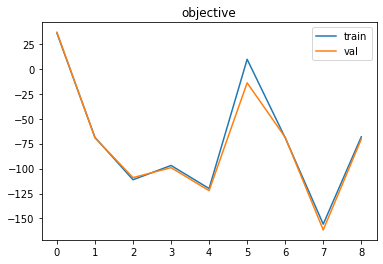

In [21]:
for loss_name in set(history[0]["losses"].keys()):
    for fold in ["train", "val"]:
        
        plt.plot(
            list(range(len(history))),
            [h["losses"][loss_name][fold] for h in history],
            label=fold
        )
    plt.title(loss_name)
    plt.legend()
    fig = plt.gcf()
    fig.savefig(experiment_path / f"history.{loss_name}.png")
    plt.show()

0.21365085 -0.16322416 0.8091807
0.19208385 -0.17095788 0.78743374
nan nan nan


ValueError: cannot convert float NaN to integer

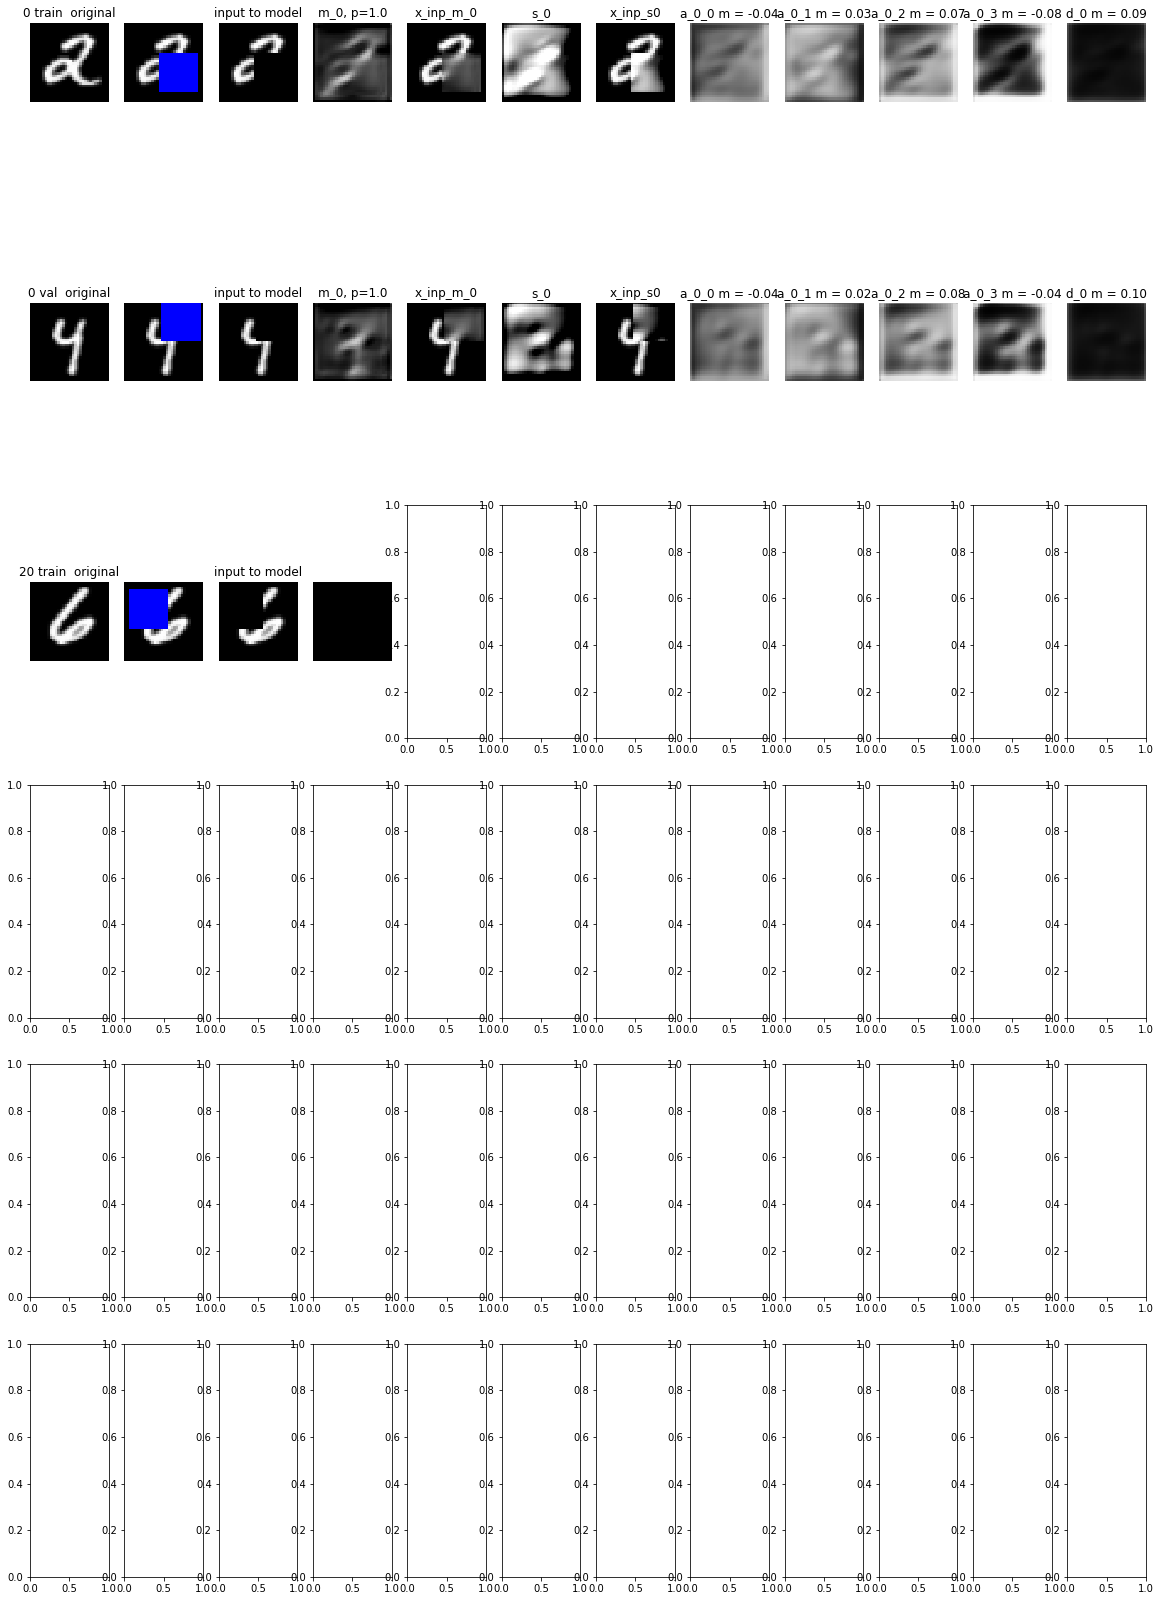

In [22]:
skip = 20

row_length = vis.row_length(*list(zip(*history[0]["sample_results"]["train"]))[0])
fig, axes = plt.subplots(
    int(np.ceil(len(history) / skip)* 2), 
    row_length,
    figsize=(20, 30)
)


for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        x, j, p, m, a, d, y = [t[0] for t in  h["sample_results"][fold]]
        row_no = (e // skip)*2 + ax_no
        print(m.mean(), m.min(), m.max())

        vis.visualize_sample(
            x, j, p, m, a, d, y, 
            ax_row=axes[row_no], 
            title_prefixes={
                0: f"{e} {fold} ",
#                 1: f"y_m = {y_masked_pred}"
            },
            drawing_fn=vis_digit_mask
        )

epochs_fig = plt.gcf()
epochs_fig.savefig(experiment_path / "epochs_renders.png")

In [ ]:
epochs_path = experiment_path / "epochs"
epochs_path.mkdir(exist_ok=True)
skip = 40
n_rows = 16

for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        
        
        row_length = vis.row_length(*list(zip(*h["sample_results"][fold]))[0])

        fig, axes = plt.subplots(
            n_rows, 
            row_length,
            figsize=(20, 30)
        )

        for row_no, (x, j, p, m ,a, d, y) in enumerate(list(zip(*h["sample_results"][fold]))[:n_rows]):
            vis.visualize_sample(
                x, j, p, m, a, d, y, 
                ax_row=axes[row_no], 
                title_prefixes={
                    0: f"{e} {fold} ",
#                     1: f"y_m = {y_masked_pred}"
                },
                drawing_fn=vis_digit_mask

            )
        
        title = f"{e}_{fold}"
        plt.suptitle(title)
        plt.savefig(epochs_path / f"{title}.png")
#       

In [ ]:
x, j, p, m, a, d, y= history[0]["sample_results"]["train"]
plt.imshow(x[0][0])

m[0][0]

In [ ]:
import pickle

with (experiment_path / "history_last_epoch.pkl").open("rb") as f:
    hist_last_epoch = pickle.load(f)

# history = [hist_last_epoch]

In [ ]:
import matplotlib.pyplot as plt

def plot_arrays_stats(
    arrays, ax=None, stat_fns = [np.min, np.max, np.mean], markers="."
):
    if ax is None:
        fig, ax = plt.subplots()
        
    if isinstance(markers, str):
        markers = [markers] * len(stat_fns)
    
    for fn, m in zip(stat_fns, markers):
        ax.scatter(
            range(len(arrays)),
            [
                fn(a) for a in arrays
            ],
            marker=m,
            label=fn.__name__
            
        )
    
    return ax

In [ ]:
for fold in ["val"]:
    x, j, p, m, a, d, y = hist_last_epoch["sample_results"][fold]

    a_resh = a.reshape(a.shape[0] * a.shape[1], a.shape[2], a.shape[3])
    covs = a_resh.transpose(0, 2, 1) @ a_resh
    
    fig, ax = plt.subplots(figsize=(20, 25), nrows=5)
    
    ax[0].set_title(f"m stats {fold}")
    plot_arrays_stats(
        m, ax[0]
    )
        
    samples = [
        vis.gans_gmms_sample_no_d(x_, m_[0], a_[0], d_[0])
        for (x_, m_, a_, d_) in zip(x, m ,a, d)
    ]
    
    ax[1].set_title("samples stats")
    plot_arrays_stats(samples, ax[1])
    
    ax[2].set_title(f"a stats {fold}")
    plot_arrays_stats(
        a, ax[2]
    )
    
    ax[3].set_title(f"d stats {fold}")
    plot_arrays_stats(
        d, ax[3]
    )
    
    ax[4].set_title(f"cov stats {fold}")
    plot_arrays_stats(
        covs, ax[4]
    )
    [a.legend() for a in ax[:5]]
    fig.savefig(experiment_path / f"outputs_stats.png")
    plt.show()
    
    cov_resh = covs[0].reshape(-1)
    plt.hist(cov_resh, log=True, bins=100)
    plt.title(f"cov[0] hist {fold}")
    plt.show()
    
    cov = covs[0]
    
    fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
    eigs = np.linalg.eigvals(cov)
    ax[0].scatter(range(len(eigs)), eigs)
    ax[0].set_title("eigenvals of cov[0]")

    cov_d = cov + np.diag(d[0])
    eigs_d = np.linalg.eigvals(cov_d)
    ax[1].scatter(range(len(eigs_d)), eigs_d)
    ax[1].set_title("eigenvals of cov[0] + d[0]")
    fig.savefig(experiment_path / "eigenvals.png")
    plt.show()

    # wygląda na to, że mamy ~3 duże wartosci własne
    
    print("m analysis")
    
    
    plt.hist(d[0].reshape(-1), bins=100, log=True)
    plt.title("d[0] hist")
    plt.show()
    
    for i in range(3):
        plt.imshow(a_resh[0, i].reshape(28,28), cmap="gray")
        plt.show()
    
    
    
    

In [ ]:
# next up
# * różne aktywacje wyjścia macierzy A (sigmoid? różne zakresy?)
# * wyplotować wielkość wartości własne A, D na przestrzeni treningu
# spróbować trenowania na niepełnych danych

In [ ]:
val_results = predictions_for_entire_loader(
    inpainter.to(torch.device("cpu")),
    dl_val,
    torch.device("cpu")
    
)
with (experiment_path / "val_predictions.pkl").open("wb") as f:
    pickle.dump(val_results, f)
    

In [ ]:
with (experiment_path / "val_predictions.pkl").open("wb") as f:
    pickle.dump(val_results, f)
    

In [ ]:
fig, ax = plt.subplots(10, 12, figsize=(15,15)
)

for i in range(10):
    vis.visualize_sample(
        *val_results[i],
        drawing_fn=vis_digit_mask,
        title_prefixes=dict(),
        ax_row=ax[i]
    )